# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [ ]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)
LC25000_test_data = np.array(LC25000_test_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))
print("The shape of LC25000_test_data: ", np.shape(LC25000_test_data))
print("The shape of LC25000_test_labels: " ,np.shape(LC25000_test_labels))

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


In [ ]:
import gc
gc.collect()

272

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_cyclegan_dir_train), "rb") as f:
    TCGA_cyclegan_train = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test), "rb") as f:
    TCGA_cyclegan_test = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_cyclegan_train['train']
TCGA_cyclegan_train_labels = TCGA_cyclegan_train['train_label']
TCGA_cyclegan_test_data = TCGA_cyclegan_test['test']
TCGA_cyclegan_test_labels = TCGA_cyclegan_test['test_label']

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (6400, 128, 128, 3)
The shape of TCGA_cyclegan_train_labels:  (6400,)
The shape of TCGA_cyclegan_test_data:  (6400, 128, 128, 3)
The shape of TCGA_cyclegan_test_labels:  (6400,)


In [ ]:
import gc
gc.collect()

253

## Datasets Visualization

<function matplotlib.pyplot.show>

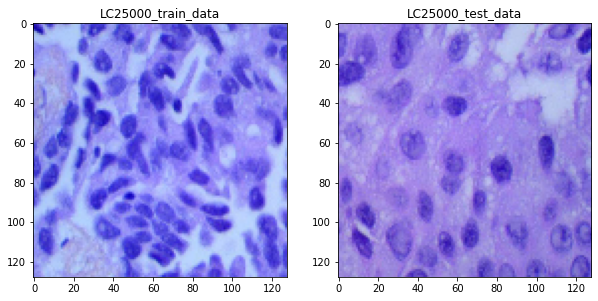

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

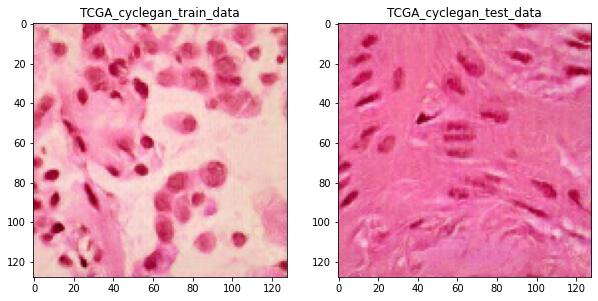

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_test_data")
plt.imshow(img2)
plt.show

In [ ]:
#LC25000_train_data, LC25000_train_labels, TCGA_cyclegan_train_data, TCGA_cyclegan_train_labels

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_128.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_128.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 4, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data (source) shape: (6400, 128, 128, 3)
TCGA_cyclegan_train_data (target) shape: (6400, 128, 128, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha), momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 23ms/step - loss: 0.4283 - acc: 0.8502 - val_loss: 1.5356 - val_acc: 0.4291
Epoch 2/5
100/100 [==============================] - 2s 19ms/step - loss: 0.1576 - acc: 0.9392 - val_loss: 2.0825 - val_acc: 0.3837
Epoch 3/5
100/100 [==============================] - 2s 19ms/step - loss: 0.1260 - acc: 0.9491 - val_loss: 2.0166 - val_acc: 0.4136
Epoch 4/5
100/100 [==============================] - 2s 19ms/step - loss: 0.1080 - acc: 0.9578 - val_loss: 2.3960 - val_acc: 0.3748
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.0967 - acc: 0.9641 - val_loss: 2.4611 - val_acc: 0.3877
Epoch 1/100
100/100 [==============================] - 6s 32ms/step - loss: 0.0813 - acc: 0.9678 - val_loss: 2.7469 - val_acc: 0.3862
Epoch 2/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0639 - acc: 0.9750 - val_loss: 2.9908 - val_acc: 0.3700
Epoch 3/100
100/100 [==============================] - 2s 25ms/step - lo

### Run 2

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha), momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 21ms/step - loss: 0.3994 - acc: 0.8648 - val_loss: 1.5579 - val_acc: 0.4338
Epoch 2/5
100/100 [==============================] - 2s 18ms/step - loss: 0.1603 - acc: 0.9383 - val_loss: 1.7581 - val_acc: 0.4270
Epoch 3/5
100/100 [==============================] - 2s 18ms/step - loss: 0.1276 - acc: 0.9469 - val_loss: 2.2095 - val_acc: 0.3914
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.1087 - acc: 0.9548 - val_loss: 2.2958 - val_acc: 0.3902
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.0886 - acc: 0.9666 - val_loss: 2.5486 - val_acc: 0.3920
Epoch 1/100
100/100 [==============================] - 4s 26ms/step - loss: 0.0780 - acc: 0.9686 - val_loss: 2.7601 - val_acc: 0.3923
Epoch 2/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0589 - acc: 0.9761 - val_loss: 3.0135 - val_acc: 0.3908
Epoch 3/100
100/100 [==============================] - 2s 22ms/step - lo

### Run 3

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha), momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 21ms/step - loss: 0.4016 - acc: 0.8662 - val_loss: 1.6886 - val_acc: 0.4155
Epoch 2/5
100/100 [==============================] - 2s 17ms/step - loss: 0.1587 - acc: 0.9384 - val_loss: 1.8575 - val_acc: 0.4167
Epoch 3/5
100/100 [==============================] - 2s 17ms/step - loss: 0.1288 - acc: 0.9492 - val_loss: 2.0636 - val_acc: 0.4005
Epoch 4/5
100/100 [==============================] - 2s 17ms/step - loss: 0.1065 - acc: 0.9570 - val_loss: 2.2980 - val_acc: 0.3917
Epoch 5/5
100/100 [==============================] - 2s 17ms/step - loss: 0.0949 - acc: 0.9627 - val_loss: 2.3634 - val_acc: 0.3913
Epoch 1/100
100/100 [==============================] - 5s 29ms/step - loss: 0.0802 - acc: 0.9670 - val_loss: 2.7730 - val_acc: 0.3852
Epoch 2/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0634 - acc: 0.9770 - val_loss: 2.8536 - val_acc: 0.4078
Epoch 3/100
100/100 [==============================] - 2s 22ms/step - lo

### Run 4

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha), momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 22ms/step - loss: 0.4079 - acc: 0.8634 - val_loss: 1.4853 - val_acc: 0.4378
Epoch 2/5
100/100 [==============================] - 2s 18ms/step - loss: 0.1587 - acc: 0.9361 - val_loss: 2.0617 - val_acc: 0.3959
Epoch 3/5
100/100 [==============================] - 2s 17ms/step - loss: 0.1273 - acc: 0.9473 - val_loss: 2.1141 - val_acc: 0.3931
Epoch 4/5
100/100 [==============================] - 2s 17ms/step - loss: 0.1062 - acc: 0.9605 - val_loss: 2.2688 - val_acc: 0.4006
Epoch 5/5
100/100 [==============================] - 2s 17ms/step - loss: 0.0939 - acc: 0.9623 - val_loss: 2.5266 - val_acc: 0.3881
Epoch 1/100
100/100 [==============================] - 4s 26ms/step - loss: 0.0797 - acc: 0.9709 - val_loss: 2.7609 - val_acc: 0.3834
Epoch 2/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0566 - acc: 0.9777 - val_loss: 3.1416 - val_acc: 0.3745
Epoch 3/100
100/100 [==============================] - 2s 22ms/step - lo

### Run 5

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha), momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 22ms/step - loss: 0.4036 - acc: 0.8637 - val_loss: 1.6983 - val_acc: 0.4198
Epoch 2/5
100/100 [==============================] - 2s 18ms/step - loss: 0.1554 - acc: 0.9391 - val_loss: 1.9273 - val_acc: 0.4067
Epoch 3/5
100/100 [==============================] - 2s 18ms/step - loss: 0.1275 - acc: 0.9506 - val_loss: 1.9545 - val_acc: 0.4209
Epoch 4/5
100/100 [==============================] - 2s 18ms/step - loss: 0.1037 - acc: 0.9600 - val_loss: 2.2232 - val_acc: 0.4072
Epoch 5/5
100/100 [==============================] - 2s 18ms/step - loss: 0.0980 - acc: 0.9611 - val_loss: 2.4916 - val_acc: 0.3952
Epoch 1/100
100/100 [==============================] - 4s 28ms/step - loss: 0.0757 - acc: 0.9702 - val_loss: 2.5862 - val_acc: 0.4033
Epoch 2/100
100/100 [==============================] - 2s 23ms/step - loss: 0.0635 - acc: 0.9756 - val_loss: 3.2647 - val_acc: 0.3709
Epoch 3/100
100/100 [==============================] - 2s 23ms/step - lo

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
100/100 [==============================] - 6s 30ms/step - loss: 1.0888 - acc: 0.4659 - val_loss: 1.0946 - val_acc: 0.4586
Epoch 2/5
100/100 [==============================] - 2s 24ms/step - loss: 0.8294 - acc: 0.6770 - val_loss: 1.0870 - val_acc: 0.4753
Epoch 3/5
100/100 [==============================] - 2s 23ms/step - loss: 0.5970 - acc: 0.7614 - val_loss: 1.1539 - val_acc: 0.4717
Epoch 4/5
100/100 [==============================] - 2s 24ms/step - loss: 0.4521 - acc: 0.8264 - val_loss: 1.3050 - val_acc: 0.4664
Epoch 5/5
100/100 [==============================] - 2s 23ms/step - loss: 0.3790 - acc: 0.8575 - val_loss: 1.4300 - val_acc: 0.4605
Epoch 1/100
100/100 [==============================] - 6s 33ms/step - loss: 0.3207 - acc: 0.8788 - val_loss: 1.5719 - val_acc: 0.4589
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.2920 - acc: 0.8880 - val_loss: 1.6697 - val_acc: 0.4555
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - lo

### Result

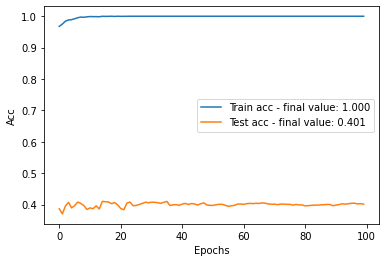

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


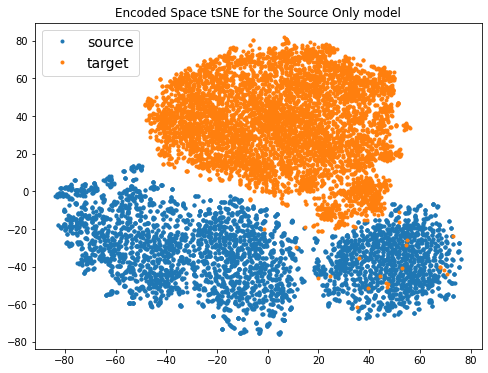

In [ ]:
LC25000_train_data_enc = finetunig.transform(LC25000_train_data_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.003457,0.998766,7.457320,0.399748
std,0.012161,0.004636,1.395844,0.006181
min,0.000002,0.967812,2.746858,0.370000
25%,0.000005,1.000000,7.211411,0.397344
50%,0.000020,1.000000,8.030804,0.400469
75%,0.000145,1.000000,8.365802,0.403437
max,0.081332,1.000000,8.554176,0.410000


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_source_Resnet_128_RMS_1e-4_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=5.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 42ms/step - loss: 0.3951 - acc: 0.8634 - disc_loss: 4.9486 - val_loss: 1.6834 - val_acc: 0.4241
Epoch 2/200
100/100 [==============================] - 4s 36ms/step - loss: 0.1455 - acc: 0.9431 - disc_loss: 2.7962 - val_loss: 1.7003 - val_acc: 0.4475
Epoch 3/200
100/100 [==============================] - 4s 37ms/step - loss: 0.1078 - acc: 0.9561 - disc_loss: 1.8732 - val_loss: 2.0933 - val_acc: 0.4319
Epoch 4/200
100/100 [==============================] - 4s 37ms/step - loss: 0.0833 - acc: 0.9686 - disc_loss: 1.4760 - val_loss: 2.5492 - val_acc: 0.4033
Epoch 5/200
100/100 [==============================] - 4s 36ms/step - loss: 0.0642 - acc: 0.9745 - disc_loss: 1.3169 - val_loss: 3.0347 - val_acc: 0.3986
Epoch 6/200
100/100 [==============================] - 4s 37ms/step - loss: 0.0495 - acc: 0.9819 - disc_loss: 1.2288 - val_loss: 3.8564 - val_acc: 0.3594
Epoch 7/200
100/100 [==============================] - 4s 37ms/step - loss: 

### Run 2

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=5.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 42ms/step - loss: 0.0307 - acc: 0.9906 - disc_loss: 15.1363 - val_loss: 22.4817 - val_acc: 0.4827
Epoch 2/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0136 - acc: 0.9948 - disc_loss: 14.9112 - val_loss: 32.3761 - val_acc: 0.4864
Epoch 3/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0189 - acc: 0.9936 - disc_loss: 15.2002 - val_loss: 46.2423 - val_acc: 0.4906
Epoch 4/200
100/100 [==============================] - 4s 35ms/step - loss: 0.1217 - acc: 0.9777 - disc_loss: 38.8016 - val_loss: 48.6134 - val_acc: 0.4917
Epoch 5/200
100/100 [==============================] - 3s 35ms/step - loss: 0.2037 - acc: 0.9641 - disc_loss: 60.3959 - val_loss: 47.3232 - val_acc: 0.4956
Epoch 6/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0999 - acc: 0.9773 - disc_loss: 65.8589 - val_loss: 48.2187 - val_acc: 0.4920
Epoch 7/200
100/100 [==============================] - 4s 35ms/s

### Run 3

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=5.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 39ms/step - loss: 0.0066 - acc: 0.9989 - disc_loss: 15.8426 - val_loss: 138.5651 - val_acc: 0.4895
Epoch 2/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0078 - acc: 0.9989 - disc_loss: 15.8744 - val_loss: 141.3528 - val_acc: 0.4881
Epoch 3/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0022 - acc: 0.9995 - disc_loss: 15.8125 - val_loss: 140.1251 - val_acc: 0.4755
Epoch 4/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0665 - acc: 0.9866 - disc_loss: 45.3985 - val_loss: 134.7099 - val_acc: 0.4625
Epoch 5/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0136 - acc: 0.9958 - disc_loss: 68.1029 - val_loss: 214.3317 - val_acc: 0.4845
Epoch 6/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0095 - acc: 0.9973 - disc_loss: 68.5912 - val_loss: 223.3402 - val_acc: 0.4903
Epoch 7/200
100/100 [==============================] - 4s 

### Run 4

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=5.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 8s 40ms/step - loss: 0.3951 - acc: 0.8633 - disc_loss: 4.9487 - val_loss: 1.6851 - val_acc: 0.4238
Epoch 2/200
100/100 [==============================] - 4s 35ms/step - loss: 0.1456 - acc: 0.9433 - disc_loss: 2.7978 - val_loss: 1.6990 - val_acc: 0.4477
Epoch 3/200
100/100 [==============================] - 4s 35ms/step - loss: 0.1079 - acc: 0.9566 - disc_loss: 1.8756 - val_loss: 2.0923 - val_acc: 0.4289
Epoch 4/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0841 - acc: 0.9688 - disc_loss: 1.4708 - val_loss: 2.5453 - val_acc: 0.4028
Epoch 5/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0642 - acc: 0.9750 - disc_loss: 1.3228 - val_loss: 3.0504 - val_acc: 0.3977
Epoch 6/200
100/100 [==============================] - 4s 35ms/step - loss: 0.0493 - acc: 0.9822 - disc_loss: 1.2266 - val_loss: 3.8741 - val_acc: 0.3587
Epoch 7/200
100/100 [==============================] - 3s 35ms/step - loss: 

### Run 5

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=5.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 39ms/step - loss: 0.0094 - acc: 0.9970 - disc_loss: 15.2391 - val_loss: 24.8813 - val_acc: 0.4744
Epoch 2/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0146 - acc: 0.9947 - disc_loss: 14.9771 - val_loss: 38.8835 - val_acc: 0.4889
Epoch 3/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0196 - acc: 0.9936 - disc_loss: 15.0797 - val_loss: 40.2320 - val_acc: 0.4872
Epoch 4/200
100/100 [==============================] - 3s 35ms/step - loss: 0.1338 - acc: 0.9717 - disc_loss: 51.2054 - val_loss: 34.4673 - val_acc: 0.4883
Epoch 5/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0713 - acc: 0.9864 - disc_loss: 65.4132 - val_loss: 37.1686 - val_acc: 0.4859
Epoch 6/200
100/100 [==============================] - 3s 35ms/step - loss: 0.0435 - acc: 0.9880 - disc_loss: 66.4929 - val_loss: 37.4105 - val_acc: 0.4883
Epoch 7/200
100/100 [==============================] - 3s 35ms/s

### Result

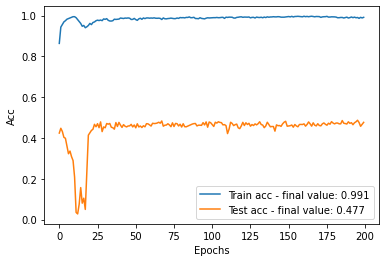

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


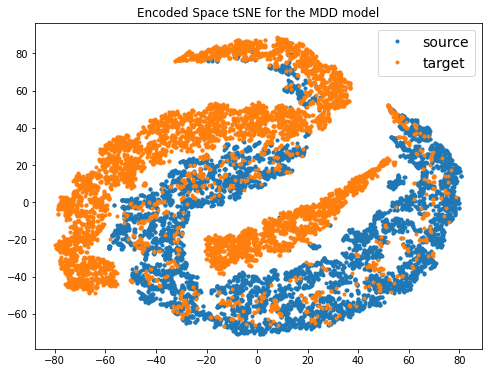

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.042362,0.985813,4.980492,13.966990,0.443398
std,0.034860,0.013282,1.240806,3.398246,0.078819
min,0.017561,0.863437,0.687728,1.683364,0.027969
25%,0.026180,0.985117,4.627070,12.474494,0.455117
50%,0.033462,0.989141,5.186591,14.237344,0.463906
75%,0.044149,0.992188,5.566380,15.834776,0.470664
max,0.395059,0.996406,9.272567,24.568409,0.486875


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_Resnet_128_RMS_1e-5_g5_cyclegan.csv")

In [ ]:
import gc
gc.collect()

13209